In [1]:
!pip install wget torchinfo
!wget -O NCT-CRC-HE-100K.zip https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
!unzip -qq NCT-CRC-HE-100K.zip -d train

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=589447163f76fec064d2b96532be24384b6b922ead951dae4be75bf6a49e1594
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
--2025-01-13 01:05:06--  https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1214456/files/NCT-CRC-HE-100K.zip [following]
--2025-01-13 01:05:07--  https://zenodo.org/records/1214456/files/NCT-CRC-HE-100K.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 11690284003 (11G) [application/octet-stream]
Saving to: ‘NCT-CRC-HE-100K.zip’

NCT-CRC-HE-100K.zip 100%[===================>] 

In [2]:
!wget -O CRC-VAL-HE-7K.zip https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip
!unzip -qq CRC-VAL-HE-7K.zip -d val

--2025-01-13 01:26:28--  https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 800276929 (763M) [application/octet-stream]
Saving to: ‘CRC-VAL-HE-7K.zip’

CRC-VAL-HE-7K.zip   100%[===================>] 763.20M  17.3MB/s    in 45s     

2025-01-13 01:27:15 (16.8 MB/s) - ‘CRC-VAL-HE-7K.zip’ saved [800276929/800276929]



In [3]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torchinfo import summary

In [4]:
class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(ConvNorm, self).__init__()
        self.linear = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return x

In [5]:
class Stem16(nn.Module):
    def __init__(self):
        super(Stem16, self).__init__()
        self.conv1 = ConvNorm(3, 32)
        self.act1 = nn.Hardswish()
        self.conv2 = ConvNorm(32, 64)
        self.act2 = nn.Hardswish()
        self.conv3 = ConvNorm(64, 128)
        self.act3 = nn.Hardswish()
        self.conv4 = ConvNorm(128, 256)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.conv4(x)
        return x

In [6]:
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):

        if x.dim() == 3:
            B, N, C = x.shape
            x = x.reshape(B * N, C)
            x = self.bn(self.linear(x))
            x = x.reshape(B, N, -1)
        else:
            x = self.bn(self.linear(x))
        return x

In [7]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_ratio=2):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        inner_dim = head_dim * num_heads * 3
        self.qkv = LinearNorm(dim, inner_dim)

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, dim)
        )

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

In [8]:
class LevitMlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(LevitMlp, self).__init__()
        self.ln1 = LinearNorm(in_features, hidden_features)
        self.act = nn.Hardswish()
        self.drop = nn.Dropout(p=0.5, inplace=False)#dropout 적용
        self.ln2 = LinearNorm(hidden_features, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.ln2(x)
        return x

In [9]:
class LevitBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=2):
        super(LevitBlock, self).__init__()
        self.attn = Attention(dim, num_heads)
        self.drop_path1 = nn.Identity()
        self.mlp = LevitMlp(dim, dim * mlp_ratio, dim)
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.attn(x))
        x = x + self.drop_path2(self.mlp(x))
        return x

In [10]:
class CNNDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNDownsample, self).__init__()
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.act = nn.Hardswish()

    def forward(self, x):
        # print(x.shape)
        B, N, C = x.shape # (B, N, C)  N=H*W (16 * 16 = 196)
        H = int(np.sqrt(N))
        x = x.view(B, H, H, C).permute(0, 3, 1, 2)
        x = self.conv(x)
        x = self.act(x)
        x = x.permute(0, 2, 3, 1).view(B, -1, self.out_channels)
        return x

In [11]:
class LevitStage(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, downsample=True):
        super(LevitStage, self).__init__()
        self.downsample = CNNDownsample(dim, out_dim) if downsample else nn.Identity()
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        x = self.downsample(x)
        x = self.blocks(x)
        return x

In [12]:
class ConvLevitStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, stride, padding):
        super(ConvLevitStage, self).__init__()
        self.layers = nn.Sequential(
            *[nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding)
              for i in range(num_blocks)],
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

In [13]:
class NormLinear(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):#drop_out_0.5 적용
        super(NormLinear, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p=dropout_prob, inplace=False)
        self.linear = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear(x)
        return x

In [14]:
class LevitDistilled(nn.Module):
    def __init__(self, num_classes=37):
        super(LevitDistilled, self).__init__()

        self.stem = Stem16()

        self.stage1 = LevitStage(dim=256, out_dim=256, num_heads=4, num_blocks=2, downsample=False) # block 수 적용
        self.stage2 = LevitStage(dim=256, out_dim=384, num_heads=6, num_blocks=2, downsample=True)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.head = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)
        self.head_dist = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)

    def forward(self, x):
        x = self.stem(x)

        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x)
        x = self.stage2(x)

        H = W = int(x.shape[1]**0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)

        x = self.conv1x1(x)

        x = torch.mean(x, dim=(2, 3))
        out = self.head(x)
        out_dist = self.head_dist(x)
        return out

In [15]:
model = LevitDistilled()
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch_size = 32
learning_rate = 0.001
num_epochs = 50

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [16]:
print(summary(model, input_size=(32, 3, 224, 224)))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 37]                  --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─ConvNorm: 2-1                                    [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    └─Hardswish: 2-2                                   [32, 32, 112, 112]        --
│    └─ConvNorm: 2-3                                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-3                                 [32, 64, 56, 56]          18,432
│    │    └─BatchNorm2d: 3-4                            [32, 64, 56, 56]          128
│    └─Hardswish: 2-4                                   [32, 64, 56, 56]          --
│    └─ConvNorm: 2-5                                  

In [17]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 37]                  --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─conv1.linear.weight                                                        ├─864
│    └─conv1.bn.weight                                                            ├─32
│    └─conv1.bn.bias                                                              ├─32
│    └─conv2.linear.weight                                                        ├─18,432
│    └─conv2.bn.weight                                                            ├─64
│    └─conv2.bn.bias                                                              ├─64
│    └─conv3.linear.weight                                                        ├─73,728
│    └─conv3.bn.weight                                                            ├─128
│    └─conv3.bn.bias              

In [22]:
train_dir = './train/NCT-CRC-HE-100K'
val_dir = './val/CRC-VAL-HE-7K'

In [23]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [24]:

train_set = datasets.ImageFolder(root=train_dir, transform=transform)

val_set = datasets.ImageFolder(root=val_dir, transform=transform)

In [25]:
# Using StratifiedShuffleSplit from sklearn
# for uniformly sample across class
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

data_paths, labels = zip(*train_set.samples)
labels = np.array(labels)

# 93:7 split (train 93K, test 7k) / validation 7k from CRC-VAL-HE-7K
train_idx, test_idx, _, tmp_labels = train_test_split(
    np.arange(len(labels)), labels, test_size=0.07, stratify=labels, random_state=42
)

In [26]:
train_data = Subset(train_set, train_idx)
test_data = Subset(train_set, test_idx)

In [28]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_data)}")

Train set size: 92999
Validation set size: 7180
Test set size: 7001


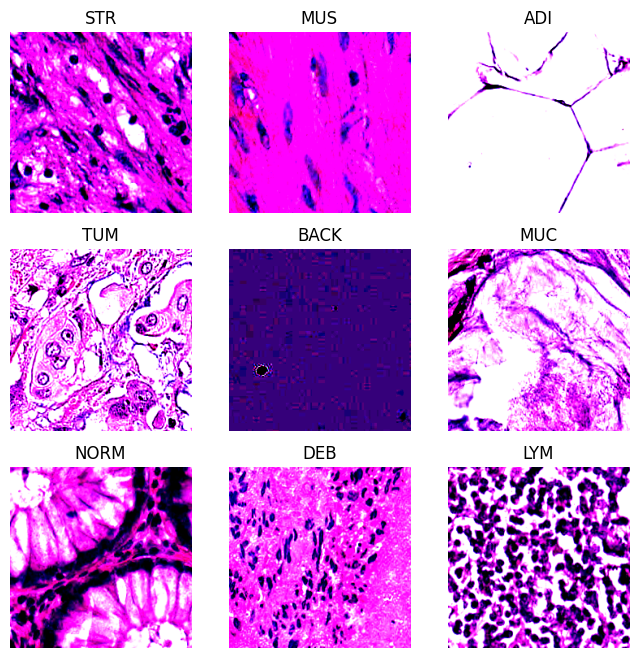

In [31]:
# Show one example per class from the training dataset
import matplotlib.pyplot as plt

dataset = train_set

# Prepare a dictionary to store one example per class
class_examples = {}
for images, labels in train_loader:
    for img, label in zip(images, labels):
        label = label.item()
        if label not in class_examples:
            class_examples[label] = img
        # Stop if we already have one example for each class
        if len(class_examples) == len(dataset.classes):
            break
    if len(class_examples) == len(dataset.classes):
        break

# Display the images and their labels
figure = plt.figure(figsize=(8, 8))
cols = 3  # You can adjust the number of columns as needed
rows = (len(dataset.classes) + cols - 1) // cols  # Calculate required rows
for i, (label, img) in enumerate(class_examples.items(), start=1):
    figure.add_subplot(rows, cols, i)
    plt.title(dataset.classes[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).numpy())  # Convert tensor to numpy for display
plt.show()

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [33]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")

In [34]:
def evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")

In [35]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [36]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, val_loader, criterion, device, phase="Validation")


Epoch 1/50


Training: 100%|██████████| 3125/3125 [03:34<00:00, 14.58it/s]


Train Loss: 0.4615, Train Accuracy: 84.17%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.27it/s]


Validation Loss: 1.3765, Validation Accuracy: 63.69%

Epoch 2/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.61it/s]


Train Loss: 0.2042, Train Accuracy: 93.12%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.51it/s]


Validation Loss: 0.5947, Validation Accuracy: 85.43%

Epoch 3/50


Training: 100%|██████████| 3125/3125 [03:31<00:00, 14.75it/s]


Train Loss: 0.1397, Train Accuracy: 95.34%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.60it/s]


Validation Loss: 1.6849, Validation Accuracy: 67.24%

Epoch 4/50


Training: 100%|██████████| 3125/3125 [03:32<00:00, 14.74it/s]


Train Loss: 0.1026, Train Accuracy: 96.61%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.50it/s]


Validation Loss: 0.5107, Validation Accuracy: 86.84%

Epoch 5/50


Training: 100%|██████████| 3125/3125 [03:32<00:00, 14.69it/s]


Train Loss: 0.0801, Train Accuracy: 97.35%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.62it/s]


Validation Loss: 0.5720, Validation Accuracy: 85.96%

Epoch 6/50


Training: 100%|██████████| 3125/3125 [03:32<00:00, 14.70it/s]


Train Loss: 0.0655, Train Accuracy: 97.82%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.32it/s]


Validation Loss: 0.6806, Validation Accuracy: 87.67%

Epoch 7/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.65it/s]


Train Loss: 0.0540, Train Accuracy: 98.21%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.61it/s]


Validation Loss: 0.5845, Validation Accuracy: 89.58%

Epoch 8/50


Training: 100%|██████████| 3125/3125 [03:32<00:00, 14.69it/s]


Train Loss: 0.0485, Train Accuracy: 98.41%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.64it/s]


Validation Loss: 0.5625, Validation Accuracy: 89.89%

Epoch 9/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.65it/s]


Train Loss: 0.0401, Train Accuracy: 98.69%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.75it/s]


Validation Loss: 0.6332, Validation Accuracy: 89.03%

Epoch 10/50


Training: 100%|██████████| 3125/3125 [03:32<00:00, 14.68it/s]


Train Loss: 0.0349, Train Accuracy: 98.85%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.66it/s]


Validation Loss: 1.4285, Validation Accuracy: 77.56%

Epoch 11/50


Training: 100%|██████████| 3125/3125 [03:32<00:00, 14.69it/s]


Train Loss: 0.0328, Train Accuracy: 98.90%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.70it/s]


Validation Loss: 0.5051, Validation Accuracy: 91.43%

Epoch 12/50


Training: 100%|██████████| 3125/3125 [03:32<00:00, 14.69it/s]


Train Loss: 0.0274, Train Accuracy: 99.09%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.57it/s]


Validation Loss: 0.9445, Validation Accuracy: 89.74%

Epoch 13/50


Training: 100%|██████████| 3125/3125 [03:32<00:00, 14.72it/s]


Train Loss: 0.0268, Train Accuracy: 99.08%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.63it/s]


Validation Loss: 0.7862, Validation Accuracy: 84.42%

Epoch 14/50


Training: 100%|██████████| 3125/3125 [03:32<00:00, 14.69it/s]


Train Loss: 0.0234, Train Accuracy: 99.22%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.52it/s]


Validation Loss: 1.2516, Validation Accuracy: 85.04%

Epoch 15/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.63it/s]


Train Loss: 0.0211, Train Accuracy: 99.32%


Validation: 100%|██████████| 225/225 [00:11<00:00, 18.77it/s]


Validation Loss: 0.6448, Validation Accuracy: 88.52%

Epoch 16/50


Training: 100%|██████████| 3125/3125 [03:32<00:00, 14.68it/s]


Train Loss: 0.0214, Train Accuracy: 99.28%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.52it/s]


Validation Loss: 0.8563, Validation Accuracy: 88.64%

Epoch 17/50


Training: 100%|██████████| 3125/3125 [03:32<00:00, 14.68it/s]


Train Loss: 0.0180, Train Accuracy: 99.37%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.58it/s]


Validation Loss: 0.8400, Validation Accuracy: 88.31%

Epoch 18/50


Training: 100%|██████████| 3125/3125 [03:32<00:00, 14.69it/s]


Train Loss: 0.0158, Train Accuracy: 99.43%


Validation: 100%|██████████| 225/225 [00:11<00:00, 18.76it/s]


Validation Loss: 1.0763, Validation Accuracy: 86.50%

Epoch 19/50


Training: 100%|██████████| 3125/3125 [03:32<00:00, 14.68it/s]


Train Loss: 0.0165, Train Accuracy: 99.44%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.48it/s]


Validation Loss: 1.0196, Validation Accuracy: 86.53%

Epoch 20/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.63it/s]


Train Loss: 0.0136, Train Accuracy: 99.56%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.67it/s]


Validation Loss: 0.6474, Validation Accuracy: 90.18%

Epoch 21/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.66it/s]


Train Loss: 0.0153, Train Accuracy: 99.48%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.62it/s]


Validation Loss: 1.4716, Validation Accuracy: 88.04%

Epoch 22/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.61it/s]


Train Loss: 0.0122, Train Accuracy: 99.60%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.51it/s]


Validation Loss: 1.4005, Validation Accuracy: 89.21%

Epoch 23/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.62it/s]


Train Loss: 0.0129, Train Accuracy: 99.57%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.64it/s]


Validation Loss: 1.4449, Validation Accuracy: 88.80%

Epoch 24/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.66it/s]


Train Loss: 0.0120, Train Accuracy: 99.60%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.43it/s]


Validation Loss: 1.0258, Validation Accuracy: 91.25%

Epoch 25/50


Training: 100%|██████████| 3125/3125 [03:32<00:00, 14.68it/s]


Train Loss: 0.0114, Train Accuracy: 99.64%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.66it/s]


Validation Loss: 1.3981, Validation Accuracy: 88.43%

Epoch 26/50


Training: 100%|██████████| 3125/3125 [03:34<00:00, 14.57it/s]


Train Loss: 0.0107, Train Accuracy: 99.62%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.66it/s]


Validation Loss: 1.7433, Validation Accuracy: 89.55%

Epoch 27/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.66it/s]


Train Loss: 0.0110, Train Accuracy: 99.64%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.55it/s]


Validation Loss: 1.4866, Validation Accuracy: 89.11%

Epoch 28/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.66it/s]


Train Loss: 0.0101, Train Accuracy: 99.64%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.43it/s]


Validation Loss: 2.3078, Validation Accuracy: 90.70%

Epoch 29/50


Training: 100%|██████████| 3125/3125 [03:32<00:00, 14.68it/s]


Train Loss: 0.0090, Train Accuracy: 99.72%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.37it/s]


Validation Loss: 1.0101, Validation Accuracy: 92.19%

Epoch 30/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.62it/s]


Train Loss: 0.0098, Train Accuracy: 99.68%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.41it/s]


Validation Loss: 1.5171, Validation Accuracy: 87.41%

Epoch 31/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.62it/s]


Train Loss: 0.0082, Train Accuracy: 99.73%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.59it/s]


Validation Loss: 1.0672, Validation Accuracy: 92.19%

Epoch 32/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.61it/s]


Train Loss: 0.0082, Train Accuracy: 99.75%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.52it/s]


Validation Loss: 1.9003, Validation Accuracy: 88.65%

Epoch 33/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.65it/s]


Train Loss: 0.0087, Train Accuracy: 99.71%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.63it/s]


Validation Loss: 1.4622, Validation Accuracy: 90.63%

Epoch 34/50


Training: 100%|██████████| 3125/3125 [03:32<00:00, 14.70it/s]


Train Loss: 0.0086, Train Accuracy: 99.72%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.57it/s]


Validation Loss: 1.6936, Validation Accuracy: 87.76%

Epoch 35/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.65it/s]


Train Loss: 0.0074, Train Accuracy: 99.73%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.58it/s]


Validation Loss: 1.0353, Validation Accuracy: 92.38%

Epoch 36/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.65it/s]


Train Loss: 0.0082, Train Accuracy: 99.74%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.45it/s]


Validation Loss: 1.3165, Validation Accuracy: 88.73%

Epoch 37/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.63it/s]


Train Loss: 0.0077, Train Accuracy: 99.75%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.38it/s]


Validation Loss: 1.5688, Validation Accuracy: 91.75%

Epoch 38/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.62it/s]


Train Loss: 0.0072, Train Accuracy: 99.78%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.56it/s]


Validation Loss: 1.2267, Validation Accuracy: 89.47%

Epoch 39/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.61it/s]


Train Loss: 0.0061, Train Accuracy: 99.81%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.30it/s]


Validation Loss: 2.5164, Validation Accuracy: 74.30%

Epoch 40/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.63it/s]


Train Loss: 0.0075, Train Accuracy: 99.76%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.51it/s]


Validation Loss: 1.2821, Validation Accuracy: 87.52%

Epoch 41/50


Training: 100%|██████████| 3125/3125 [03:34<00:00, 14.55it/s]


Train Loss: 0.0064, Train Accuracy: 99.78%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.44it/s]


Validation Loss: 1.0570, Validation Accuracy: 89.25%

Epoch 42/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.64it/s]


Train Loss: 0.0063, Train Accuracy: 99.79%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.35it/s]


Validation Loss: 0.7427, Validation Accuracy: 91.67%

Epoch 43/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.64it/s]


Train Loss: 0.0065, Train Accuracy: 99.80%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.09it/s]


Validation Loss: 0.8239, Validation Accuracy: 92.48%

Epoch 44/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.61it/s]


Train Loss: 0.0062, Train Accuracy: 99.79%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.55it/s]


Validation Loss: 0.7485, Validation Accuracy: 92.84%

Epoch 45/50


Training: 100%|██████████| 3125/3125 [03:34<00:00, 14.55it/s]


Train Loss: 0.0057, Train Accuracy: 99.80%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.38it/s]


Validation Loss: 1.0642, Validation Accuracy: 89.89%

Epoch 46/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.63it/s]


Train Loss: 0.0062, Train Accuracy: 99.80%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.57it/s]


Validation Loss: 1.2551, Validation Accuracy: 91.52%

Epoch 47/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.63it/s]


Train Loss: 0.0057, Train Accuracy: 99.82%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.27it/s]


Validation Loss: 1.6241, Validation Accuracy: 83.72%

Epoch 48/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.61it/s]


Train Loss: 0.0050, Train Accuracy: 99.84%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.46it/s]


Validation Loss: 1.7433, Validation Accuracy: 85.57%

Epoch 49/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.64it/s]


Train Loss: 0.0058, Train Accuracy: 99.82%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.36it/s]


Validation Loss: 2.3016, Validation Accuracy: 87.38%

Epoch 50/50


Training: 100%|██████████| 3125/3125 [03:33<00:00, 14.62it/s]


Train Loss: 0.0054, Train Accuracy: 99.83%


Validation: 100%|██████████| 225/225 [00:12<00:00, 18.69it/s]

Validation Loss: 1.2113, Validation Accuracy: 88.01%


In [37]:
print("\nFinal Test Evaluation")
evaluate(model, test_loader, criterion, device, phase="Test")


Final Test Evaluation


Test: 100%|██████████| 219/219 [00:11<00:00, 18.84it/s]

Test Loss: 0.0008, Test Accuracy: 99.97%


In [38]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 219
Average Time: 5.47 ms
Standard Deviation: 0.12 ms
Maximum Time: 5.99 ms
Minimum Time: 5.27 ms


In [39]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::matmul         1.77%     352.574us        16.06%       3.202ms     133.408us       0.000us         0.00%       2.522ms     105.066us            24  
                                           aten::linear         0.52%     104.040us        11.99%       2.391ms     132.855us       0.000us         0.00%       1.822ms     101.206us            18  
         

In [40]:
save_path = "HoViT_NCT-CRC-HE-100K.pth"
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Model weights saved to HoViT_NCT-CRC-HE-100K.pth
